In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('alll.csv')

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data=data.query('accuracy=="1/1"&status=="Accepted"')#只要用accuracy是1/1，status是accepted的数据，为了控制变量。

In [4]:
data.shape#有26W数据

(264442, 12)

In [5]:
data.isnull().sum()#没有空值

submission_id        0
problem_id           0
user_id              0
date                 0
language             0
original_language    0
filename_ext         0
status               0
cpu_time             0
memory               0
code_size            0
accuracy             0
dtype: int64

In [6]:
data['code_size'].describe()#8000比较合理

count    264442.000000
mean       1008.260371
std        1362.438512
min          11.000000
25%         315.000000
50%         622.000000
75%        1214.000000
max       60757.000000
Name: code_size, dtype: float64

In [7]:
array=np.arange(0,8500,500)
array

array([   0,  500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
       5500, 6000, 6500, 7000, 7500, 8000])

In [8]:
data['cat_code']=pd.cut(data['code_size'],bins=array)

In [9]:
data

,submission_id,problem_id,user_id,date,language,original_language,filename_ext,status,cpu_time,memory,code_size,accuracy,cat_code
1,s554950692,p00000,u706566315,1540908314,Rust,Rust,rs,Accepted,0.0,5004.0,124,1/1,"(0, 500]"
2,s555203498,p00000,u759934006,1513417513,Rust,Rust,rs,Accepted,0.0,5020.0,136,1/1,"(0, 500]"
3,s309783173,p00000,u233505136,1516826051,Rust,Rust,rs,Accepted,0.0,5004.0,123,1/1,"(0, 500]"
4,s184977351,p00000,u191088660,1517740150,Rust,Rust,rs,Accepted,0.0,5004.0,122,1/1,"(0, 500]"
5,s171709297,p00000,u444102531,1518453505,Rust,Rust,rs,Accepted,0.0,5008.0,108,1/1,"(0, 500]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1944461,s506261030,p02525,u358792510,1340468710,C,C,c,Accepted,0.0,0.0,416,1/1,"(0, 500]"
1944462,s548967462,p02525,u975905396,1341066552,C,C,c,Accepted,0.0,0.0,560,1/1,"(500, 1000]"
1944824,s751921273,p02525,u444904956,1335601711,C++,C++,cpp,Accepted,0.0,0.0,378,1/1,"(0, 500]"
1944825,s868124794,p02525,u055278086,1337230147,C++,C++,cpp,Accepted,0.0,0.0,493,1/1,"(0, 500]"


In [10]:
fig_data=data.loc[:,['language','cpu_time','memory','cat_code']]

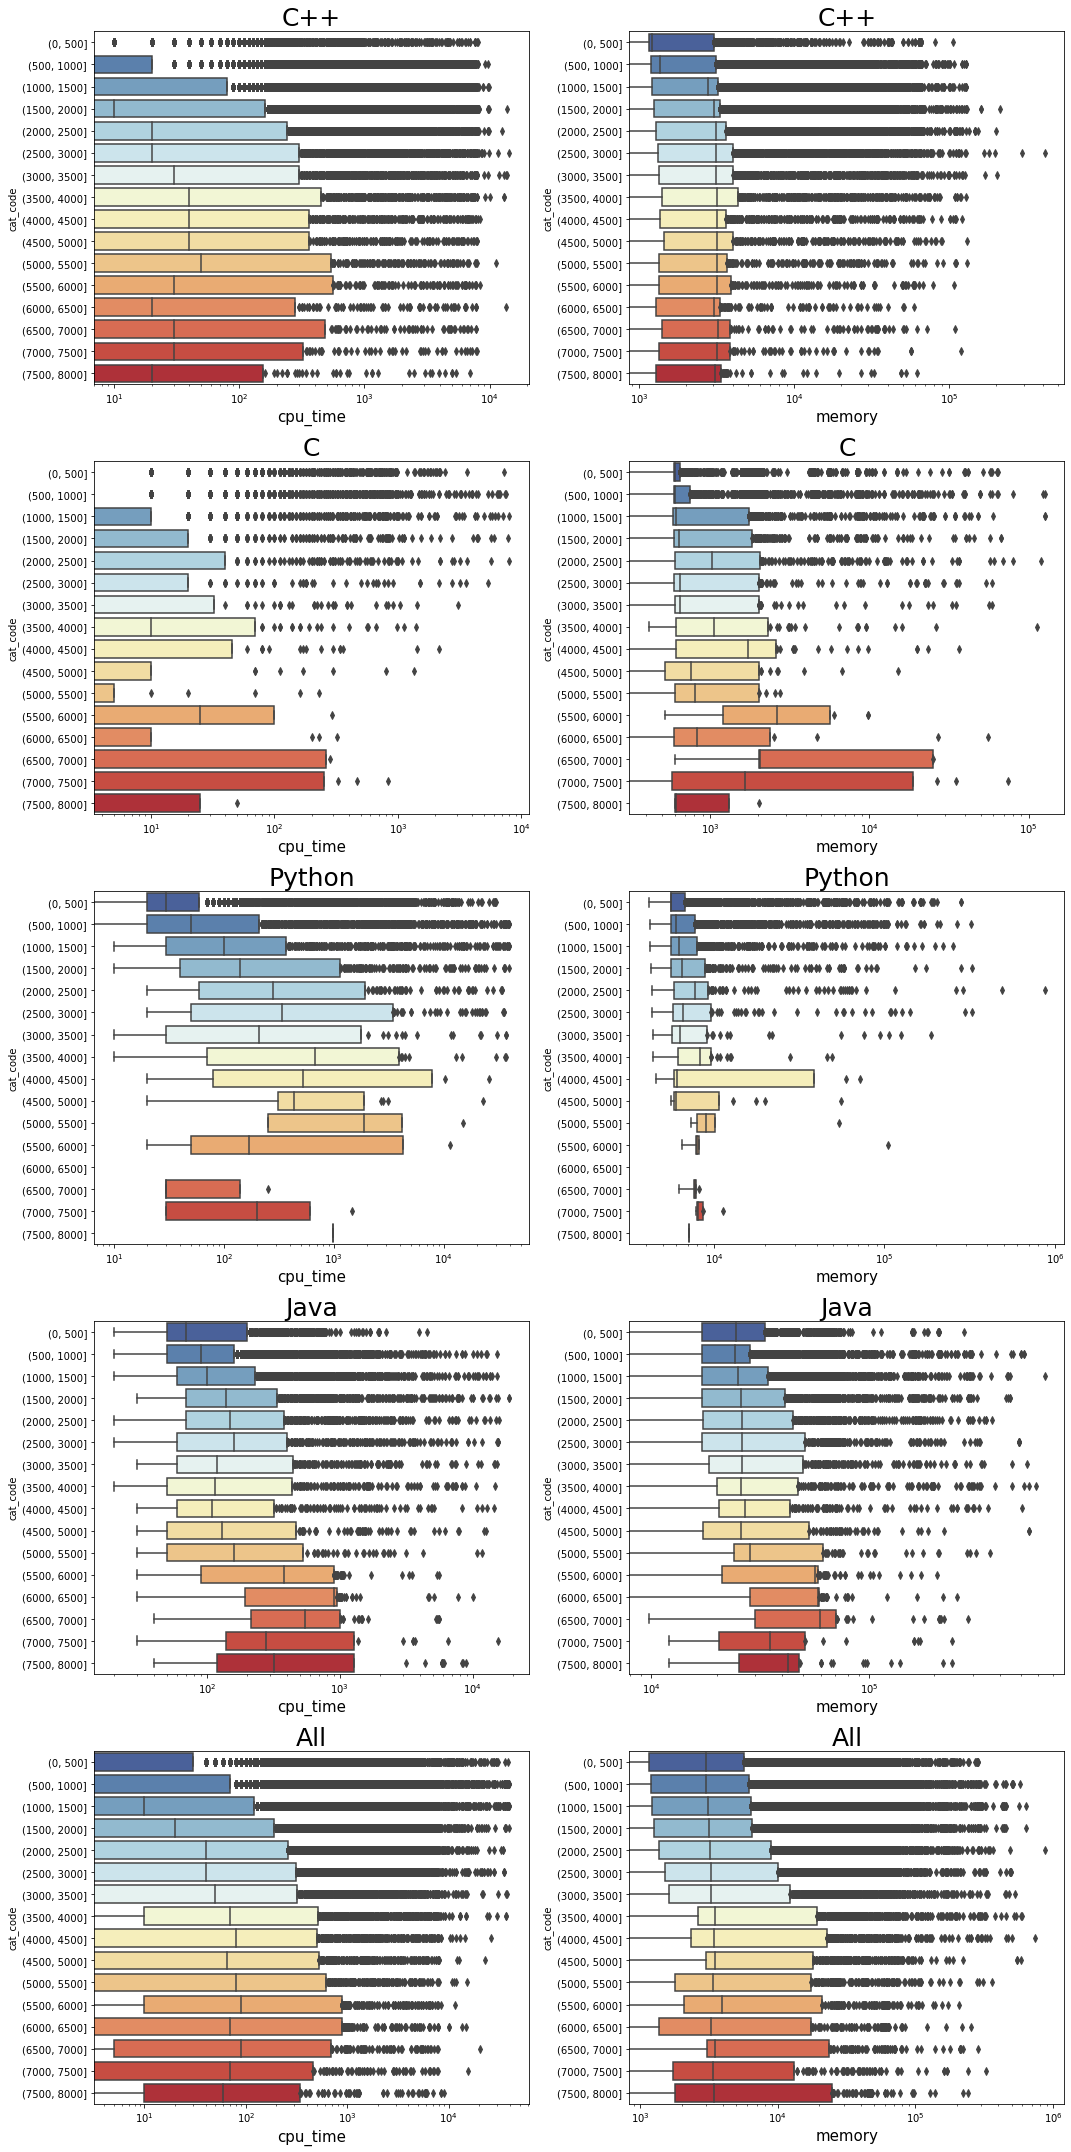

In [11]:
fig,ax=plt.subplots(5,2,figsize=[15,30])
for row,language in enumerate(['C++','C','Python','Java','All']):
    for col,variable in enumerate(['cpu_time','memory']):
        if language!='All':
            df=fig_data.query('language=="{}"'.format(language))
        else:
            df=fig_data
        sns.boxplot(data=df,y='cat_code',x=variable,ax=ax[row,col],palette='RdYlBu_r',whis=[0,50])
        ax[row,col].set_xscale('log')
        ax[row,col].set_xlabel(variable,fontsize=15)
        ax[row,col].set_title(language,fontsize=25)
plt.tight_layout()
plt.savefig('logscale.png',dpi=600, bbox_inches='tight')
plt.show()

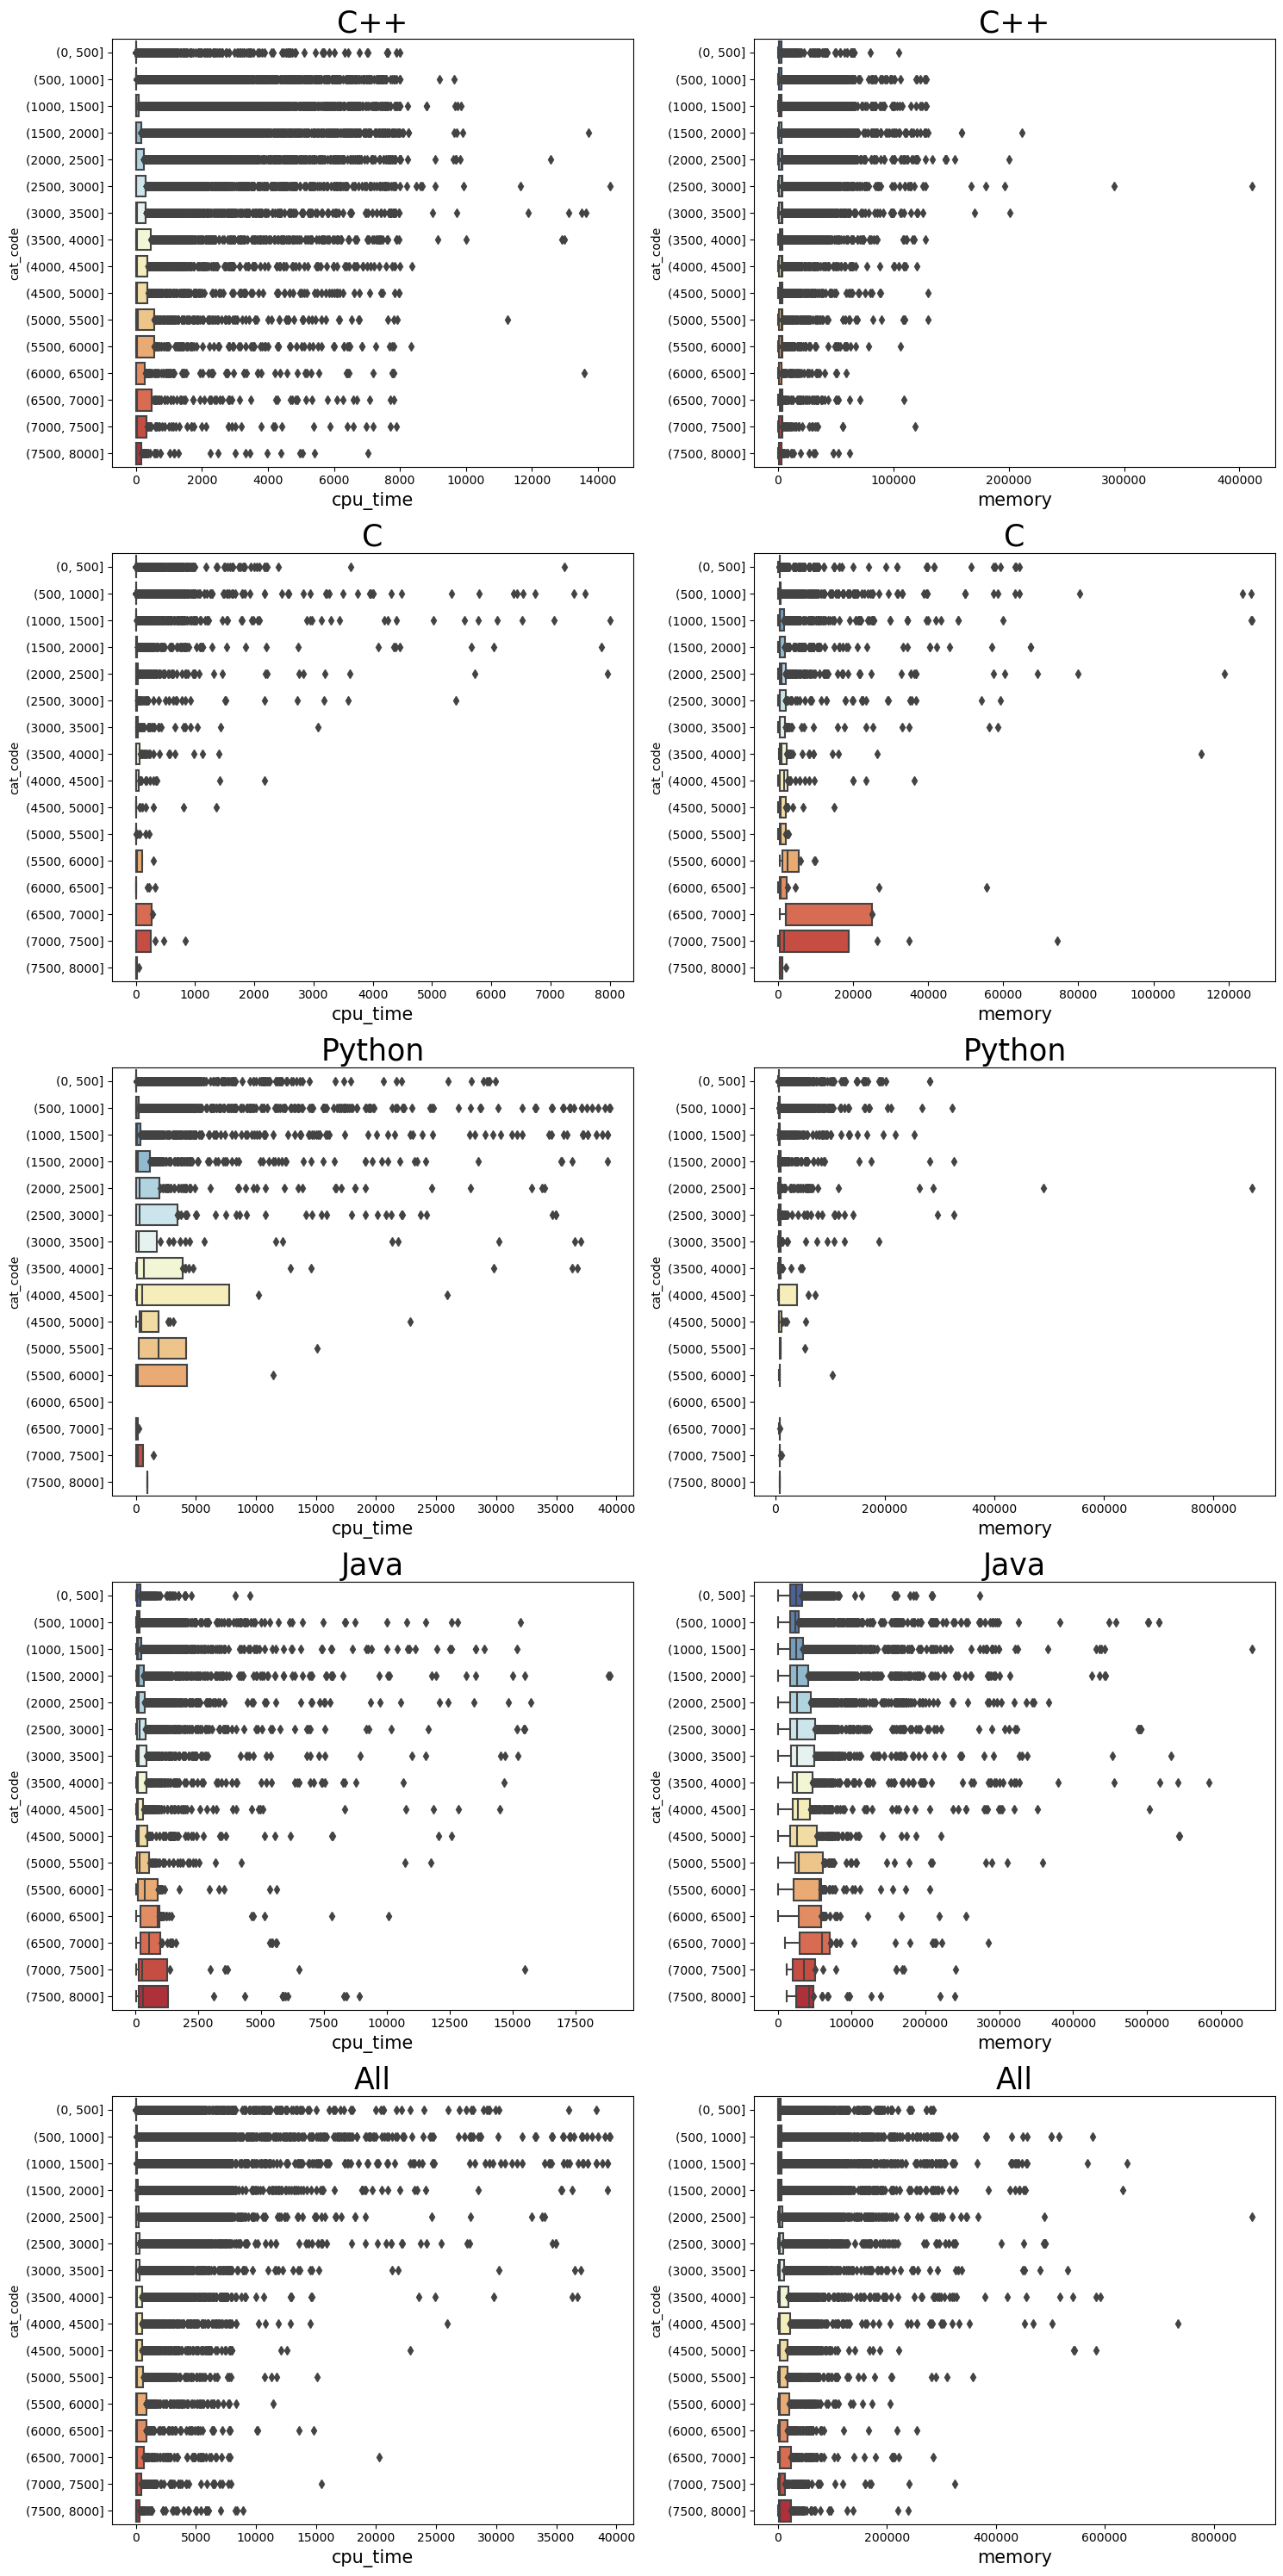

In [13]:
fig,ax=plt.subplots(5,2,figsize=[15,30])
for row,language in enumerate(['C++','C','Python','Java','All']):
    for col,variable in enumerate(['cpu_time','memory']):
        if language!='All':
            df=fig_data.query('language=="{}"'.format(language))
        else:
            df=fig_data
        sns.boxplot(data=df,y='cat_code',x=variable,ax=ax[row,col],palette='RdYlBu_r',whis=[0,70])
        ax[row,col].set_xlabel(variable,fontsize=15)
        ax[row,col].set_title(language,fontsize=25)
plt.tight_layout()
plt.savefig('normal.png',dpi=600, bbox_inches='tight')
plt.show()

In [12]:
languages=['C++','C','Python','Java','All']

In [13]:
data=data.loc[:,['problem_id','language','cpu_time','memory','code_size']]

In [14]:
data=data[data['language'].isin(languages)]

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [16]:
def highlight_greaterthan(s, threshold, color='orange'):
    return 'background-color: {}'.format(color) if s > threshold else ''


def cv(df,model):#5折交叉验证
    size=len(df)
    if size<20:
        return pd.DataFrame([[0,0,0,0,0]],columns=['code_cpu','code_memory','code+memory_cpu','code+cpu_memory','size'])
    
    cpu=np.mean(cross_val_score(model(),df[['code_size']],df['cpu_time'],scoring='r2',n_jobs=-1))
    memory=np.mean(cross_val_score(model(),df[['code_size']],df['memory'],scoring='r2',n_jobs=-1))
    cm=np.mean(cross_val_score(model(),df[['code_size','memory']],df['cpu_time'],scoring='r2',n_jobs=-1))
    cc=np.mean(cross_val_score(model(),df[['code_size','cpu_time']],df['memory'],scoring='r2',n_jobs=-1))
    return pd.DataFrame([[cpu,memory,cm,cc,size]],columns=['code_cpu','code_memory','code+memory_cpu','code+cpu_memory','size'])




def just_fit(df,model):#仅仅只是拟合
    size=len(df)
    if size<20:
        return pd.DataFrame([[0,0,0,0,0]],columns=['code_cpu','code_memory','code+memory_cpu','code+cpu_memory','size'])
    reg=model().fit(df[['code_size']],df['cpu_time'])
    cpu=metrics.r2_score(df['code_size'],reg.predict(df[['code_size']]))

    reg=model().fit(df[['code_size']],df['memory'])
    memory=metrics.r2_score(df['memory'],reg.predict(df[['code_size']]))

    reg=model().fit(df[['code_size','memory']],df['cpu_time'])
    cm=metrics.r2_score(df['cpu_time'],reg.predict(df[['code_size','memory']]))
    
    reg=model().fit(df[['code_size','cpu_time']],df['memory'])
    cc=metrics.r2_score(df['memory'],reg.predict(df[['code_size','cpu_time']]))
    
    return pd.DataFrame([[cpu,memory,cm,cc,size]],columns=['code_cpu','code_memory','code+memory_cpu','code+cpu_memory','size'])

In [17]:
data=data[(data.iloc[:,2:]>0).all(1)]#过滤掉 cup memory codesize为0的部分

In [18]:
cv_out_linear=data[data.code_size<3000].groupby(['language']).apply(lambda df:cv(df,LinearRegression))
r10=cv_out_linear[(cv_out_linear.iloc[:,:-1]>-10).any(1)].style.applymap(highlight_greaterthan, threshold=-10)
r10

,,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
language,,,,,,
C,0,-0.034658,0.021059,-0.042514,0.022474,3649
C++,0,-0.113114,0.003569,-0.084867,0.024001,49023
Java,0,-0.845033,-0.447920,-0.326892,-0.261165,24454
Python,0,-0.423899,-0.012946,-0.306329,0.077201,27736


In [19]:
cv_out_mlp=data[data.code_size<3000].groupby(['language']).apply(lambda df:cv(df,MLPRegressor))
r11=cv_out_mlp[(cv_out_mlp.iloc[:,:-1]>-10).any(1)].style.applymap(highlight_greaterthan, threshold=-10)
r11

,,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
language,,,,,,
C,0,-0.036146,0.010704,-0.053410,0.001781,3649
C++,0,-0.112517,-0.002520,-0.047704,0.059593,49023
Java,0,-0.848545,-0.769104,-0.336055,-0.185203,24454
Python,0,-0.459187,-0.045468,-0.888620,-0.023975,27736


In [20]:
cv_out_rf=data[data.code_size<3000].groupby(['language']).apply(lambda df:cv(df,RandomForestRegressor))
r12=cv_out_rf[(cv_out_rf.iloc[:,:-1]>-10).any(1)].style.applymap(highlight_greaterthan, threshold=-10)
r12

,,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
language,,,,,,
C,0,-1.175306,-0.575993,-0.702749,-0.450033,3649
C++,0,-0.297785,-0.108780,-0.628193,-0.199437,49023
Java,0,-2.933160,-1.015089,-1.707644,-0.042190,24454
Python,0,-2.457924,-0.335271,-1.499995,-0.089454,27736


In [21]:
cv(data,LinearRegression)

,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
0,-0.222391,0.010172,-0.223411,0.026969,112975


In [22]:
cv(data,MLPRegressor)

,code_cpu,code_memory,code+memory_cpu,code+cpu_memory,size
0,-0.160667,0.009547,-0.040553,0.059323,112975


In [ ]:
cv(data,RandomForestRegressor)